# Day 1: Intro to Stacking + Dataset Setup



In [2]:
#download data from kaggle
!pip install opendatasets

In [3]:
import pandas as pd
import numpy as np
import opendatasets as od
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib

In [4]:
# imputing missing values in num_cols
from sklearn.impute import SimpleImputer
# scaling numeric value in 1-0 range
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer
# Combine the numerical and categorical pipelines
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
od.download("https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?select=loan_data.csv")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hemantk777
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data


100%|██████████| 751k/751k [00:00<00:00, 331MB/s]

In [7]:
df=pd.read_csv("/content/loan-approval-classification-data/loan_data.csv")

In [8]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [10]:
## preprocess
# drop na
df.dropna(inplace=True)

# Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Split features and target
x = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)


In [12]:
# Base Models Setup
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb = LGBMClassifier(n_estimators=100, random_state=42)


# Day 2: Train Base Models + Stack with Meta Learner

In [13]:
# import core tools
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [14]:
# Initialize Stacking Setup
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to store base model predictions
train_stack = np.zeros((X_train.shape[0], 3))  # 3 base models
test_stack = np.zeros((X_test.shape[0], 3))

In [15]:
skf

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [16]:
# 3 base models (RandomForest, XGBoost, LightGBM)
base_models = [rf, xgb, lgb]

# Loop over each base model
for i, model in enumerate(base_models):

    # For storing predictions of each fold on the test set
    fold_test_preds = np.zeros((X_test.shape[0], n_folds))

    # K-Fold cross-validation loop
    for j, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Split data for this fold
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]

        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Train model on current fold
        model.fit(X_fold_train, y_fold_train)

        # Predict on validation set (for stacking training)
        val_preds = model.predict_proba(X_fold_val)[:, 1]  # only prob for class 1

        # Store predictions in train_stack (correct positions)
        train_stack[val_idx, i] = val_preds

        # Predict on test set and store in fold-specific column
        fold_test_preds[:, j] = model.predict_proba(X_test)[:, 1]

    # Average predictions from all folds for final test prediction
    test_stack[:, i] = fold_test_preds.mean(axis=1)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

In [17]:
#  Train Meta Learner
meta_model = LogisticRegression()
meta_model.fit(train_stack, y_train)

LogisticRegression()

In [18]:
#  Final Evaluation
final_preds = meta_model.predict(test_stack)

print("Stacked Model Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))

Stacked Model Accuracy: 0.9352222222222222
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7000
           1       0.89      0.80      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.94      0.93      9000



In [19]:
# Check Individual vs Stacked Accuracy
for name, model in zip(['RF', 'XGB', 'LGBM'], base_models):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")

RF Accuracy: 0.9281
XGB Accuracy: 0.9336
LGBM Accuracy: 0.9331


In [20]:
import joblib

# Save base learners
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(lgb, 'lgb_model.pkl')

# Save meta learner
joblib.dump(meta_model, 'stacked_meta_model.pkl')


['stacked_meta_model.pkl']

In [21]:
##Visual (Optional) — Stacked Learning Flow
'''Train Data  →  [ RF | XGB | LGBM ]
                       ↓
         Val Predictions (Level 1)
                       ↓
        LogisticRegression (Meta)
                       ↓
              Final Prediction ✅'''

'Train Data  →  [ RF | XGB | LGBM ]\n                       ↓\n         Val Predictions (Level 1)\n                       ↓\n        LogisticRegression (Meta)\n                       ↓\n              Final Prediction ✅'

# Day 6: SHAP Interpretability for Stacked Models

In [1]:
!pip install shap
import shap

In [29]:
shap.plots.backend = "matplotlib"   # Use matplotlib backend for plots

In [22]:
#  Fit Models for SHAP (XGB & LGBM)
xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763


LGBMClassifier(random_state=42)

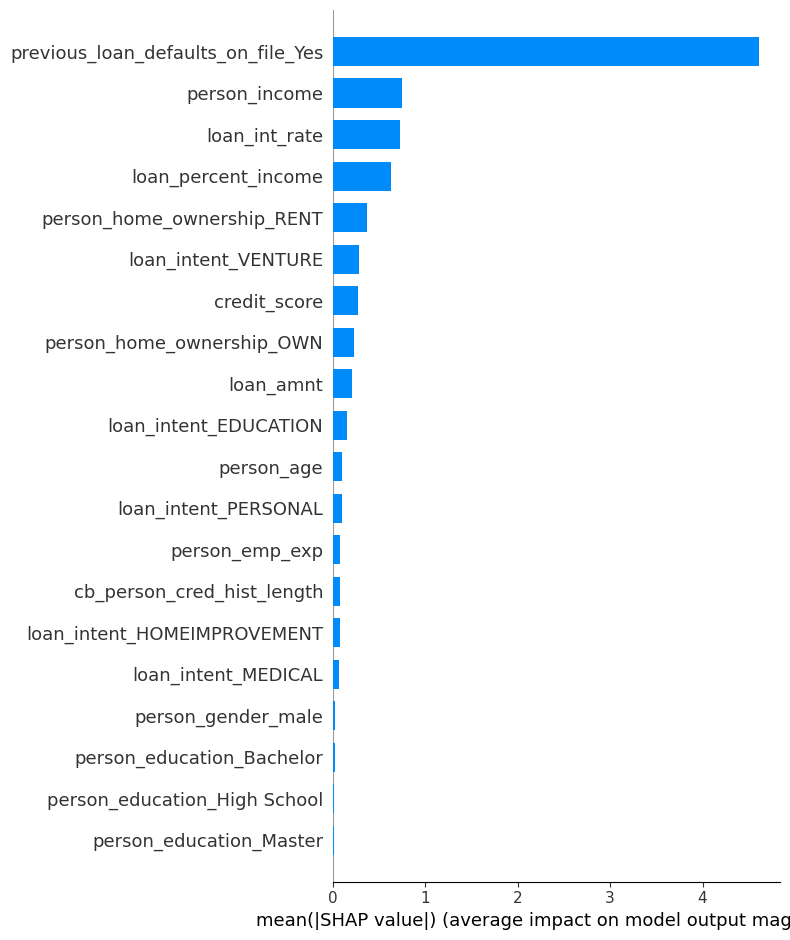

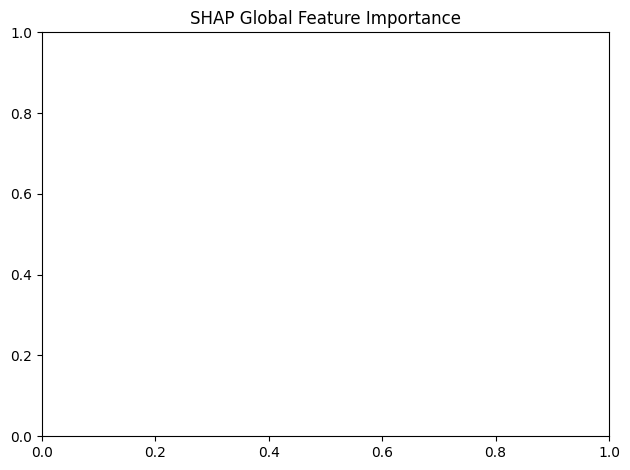

In [32]:
# SHAP Summary Plot (Global Feature Importance)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("SHAP Global Feature Importance")
plt.tight_layout()
#plt.savefig("shap_summary_plot_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

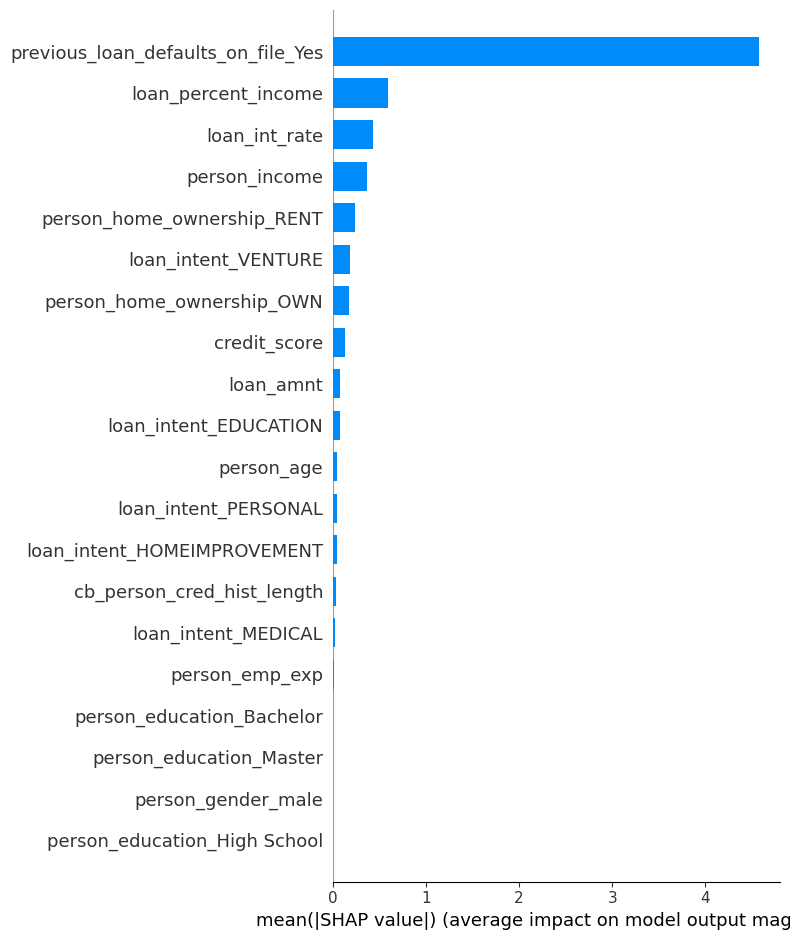

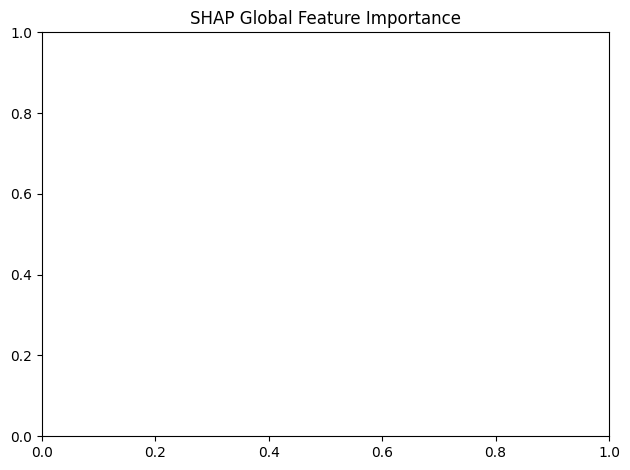

In [31]:
#  LightGBM SHAP Explanation
explainer_lgb = shap.Explainer(lgb)
shap_values_lgb = explainer_lgb(X_train)

shap.summary_plot(shap_values_lgb, X_train, plot_type="bar")
plt.title("SHAP Global Feature Importance")
plt.tight_layout()
#plt.savefig("shap_summary_plot_LGB.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#  SHAP Force Plot (Individual Prediction)
sample = X_test.iloc[0:1]      # Pick one example

shap.initjs()
shap_values = explainer(sample)

shap_html=shap.force_plot(explainer.expected_value, shap_values.values[0], sample)
# shap.save_html("shap_force_plot.html", shap_html)    saving images
shap_html

## Author
Hemant K  
📧 hemant777.karpe@gmail.com
🔗 [LinkedIn](https://www.linkedin.com/in/hemant-karpe)